<center> <font size='6' font-weight='bold'> Projet Centrale </font> </center>  
<center> <i> Puzzle</i> </center>
<center> <i> Tony WU </i> </center>  
  
  
<img src=ressources/image_couverture.jpg>

# Préliminaires

## Objectifs

Le problème est le suivant. Une image a été découpée en morceaux rectangulaires **plus ou moins** de mêmes dimensions et ces morceaux ont ensuite été changé de place. L'objectif est de créer un algorithme qui prendrait le puzzle en entrée et renverrait l'image d'origine.  

**On peut décomposer le problème en plusieurs parties :** 
  
1) Récupérer les pièces de puzzle.
    
2) FORCE BRUTE: On va essayer toutes les permutations possibles de pièces, au nombre de $(n_{lignes} \times n_{colonnes})!$  
  - En fait, comme ce nombre est trop important, on va, lors de la construction de l'image finale, ne garder que les configurations qui présentent en faible gradient sur les bords. Pour définir la notion de faible gradient, on va se dire arbitrairement que si le gradient calculé est dans l'intervalle ±5% du gradient moyen calculé sur les bords de l'image d'origine, alors on rejette la solution actuelle et on passe à la suivante.

4) On crée une sorte de fonction coût, disons par exemple, pour une image en niveaux de gris :
\begin{equation}
J = \sum_{\text{bords des pièces}} (\vec{\nabla{u}} \dot \vec{n})^2
\end{equation}
    
Ainsi, l'objectif sera de trouver la configuration de puzzle qui minimise $J$.

## Modules

In [34]:
import numpy as np
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import os
from itertools import permutations
from IPython.display import clear_output

# Découpage de l'image

**Rappel important**
Avec PIL, le système de coordonées pris est le suivant :
<img src=ressources/coords_system.png>

In [50]:
def read_img(filename):
    return Image.open(filename)

In [51]:
def split_img(im_shuffled, nb_lines, nb_cols):
    '''Returns a dictionary of all the pieces of the puzzle.'''
    w, h = im_shuffled.size # w, h = width, height
    
    # For one piece of the puzzle
    w_piece = w / nb_cols
    h_piece = h / nb_lines
    
    cropped = {}
    
    for i in range(nb_lines):
        for j in range(nb_cols):
            left = i * w_piece
            top = j * h_piece
            right = (i + 1) * w_piece
            bottom = (j + 1) * h_piece
            
            cropped[(i,j)] = im_shuffled.crop((left, top, right, bottom))
    
    return cropped

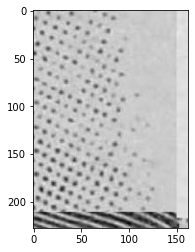

In [52]:
filename = 'img_test.jpg'
nb_lines = 9
nb_cols = 9

im_shuffled = read_img(filename)

cropped = split_img(im_shuffled, nb_lines, nb_cols)

plt.imshow(cropped[(0,0)])

In [22]:
def save_cropped(cropped):
    '''Save all the pieces of the puzzle in the cropped directory.
    Input:
        - cropped: dictionary {key: image}'''
    
    for (i,j), im in cropped.items():
        filename = f'{i}-{j}.jpg'
        filepath = os.path.join('cropped', filename)
        im.save(filepath)
    print('Images successfully saved.')
    return

In [ ]:
save_cropped(cropped)

# FORCE BRUTE

## Obtention des permutations

In [5]:
def get_current_permutations(cropped):
    ''' Generator that yields a dictionary giving the mapping from the current
    configuration to the shuffled puzzle.'''
    
    list_keys = list(cropped.keys())
    
    for config in permutations(list_keys):
        map_config = dict(zip(list_keys, config))
        yield map_config

## Calcul du gradient

On essaie de garder les couleurs pour la configuration finale donc on somme le gradient pour chaque canal de couleur.

In [41]:
im1 = cropped[(0,0)]
im2 = cropped[(0,1)]

In [69]:
def grad_x(im1, im2):
    '''Return the discrete horizontal gradient. im2 must be to the right of im1.'''
    
    ## Conversion into numpy arrays
    arr1 = np.array(im1)
    arr2 = np.array(im2)
    
    min_x = min(arr1.shape[0], arr2.shape[0])
    min_y = min(arr1.shape[1], arr2.shape[1])
    
    arr1 = arr1[:min_x,:min_y,:]
    arr2 = arr2[:min_x,:min_y,:]
    
    ## Computation of the horizontal gradient at the frontier
    return np.sum(np.square(arr1[-1,:,:] - arr2[0,:,:]))

In [70]:
def grad_y(im1, im2):
    '''Return the discrete vertical gradient. im2 must be BELOW im1.
    NB: numpy and PIL don't share the same coordinate system! '''
    
    ## Conversion into numpy arrays
    arr1 = np.array(im1)
    arr2 = np.array(im2)
    
    min_x = min(arr1.shape[0], arr2.shape[0])
    min_y = min(arr1.shape[1], arr2.shape[1])
    
    arr1 = arr1[:min_x,:min_y,:]
    arr2 = arr2[:min_x,:min_y,:]
    
    ## Computation of the horizontal gradient at the frontier
    return np.sum(np.square(arr1[:,0,:] - arr2[:,-1,:]))

In [75]:
def mean_grad(cropped, nb_lines, nb_cols):
    res = 0
    for j in range(nb_lines):
        for i in range(nb_cols-1):  
            res += grad_x(cropped[(i,j)], cropped[(i+1,j)])
    return res / (nb_lines * nb_cols)

In [76]:
grad_x(im1, im2)

50418

In [77]:
grad_y(im1, im2)

69978

In [78]:
mean_grad(cropped, nb_lines, nb_cols)

44700.851851851854

## Assemblage du puzzle

Ci-dessous, on définit quelques fonctions outils utiles pour `create_config`.

In [10]:
def read_cropped_im(i, j):
    ''' Returns the given image loaded from the cropped folder.'''
    im = Image.open(os.path.join('cropped', f'{i}-{j}.jpg'))
    return im

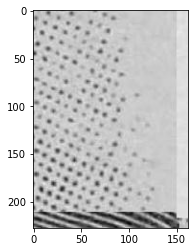

In [11]:
im_test = read_im(0, 0)
plt.imshow(im_test)

In [12]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [14]:
def create_config(map_config, nb_lines, nb_cols):
    '''
    Returns an image according to the given configuration.
    Strategy:
        1) We'll start concatenate each line of the final configuration.
        2) Only then are we going to concatenate those lines vertically.
    
    Input:
        - map_config: dictionary mapping from the current
                        configuration to the shuffled puzzle.
        - nb_lines
        - nb_cols
    '''
    
    ## Step 1:
    list_lines = []
    
    for j in range(nb_lines): # We process line by line...
        # We start from the left-most image.
        current_im = read_cropped_im(*map_config[(0,j)]) # NB: The * allows to unpack the given tuple
        
        for i in range(1, nb_cols): # For each piece of the line...
            new_piece = read_cropped_im(*map_config[(i,j)]) # we get the juxtaposed piece just right to the previous one
            
            current_im = get_concat_h(current_im, new_piece)
        
        list_lines.append(current_im)
    
    # Now we can vertically concatenate the obtained lines.
    current_im = list_lines[0]
    
    for idx, img_line in enumerate(list_lines):
        if idx == 0:
            pass
        else:
            current_im = get_concat_v(current_im, img_line)
    
    return current_im

In [19]:
map_config = next(get_current_permutations(cropped))
create_config(map_config, nb_lines, nb_cols)

In [33]:
for idx, map_config in enumerate(get_current_permutations(cropped)):
    print(f'Current configuration: {idx}')
    im_config = create_config(map_config, nb_lines, nb_cols)
    filename = f'{idx}.jpg'
    filepath = os.path.join('outputs', filename)
    im_config.save(filepath)
    clear_output(wait=True)

Current configuration: 11


KeyboardInterrupt: 

A ajouter :
- Si lorsqu'on essaie de coller deux pièces telles que le gradient dans la direction de concaténation est supérieur à la moyenne des gradients du puzzle mélangé, alors on `break` la boucle en cours et on passe directement à la configuration suivate.